# Fouth model: Random forest with TFIDF + complexity features

In [62]:
import time
start = time.time()

import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize, sent_tokenize
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score

In [63]:
df = pd.read_csv('../data/spanish_corpus_features_v4.csv')
df.head()

,text,headline,n_sents,n_words,avg_words_sents,word_size,unique_words,ttr,mltd,n_words_h,...,propn_ratio,noun_ratio,adp_ratio,det_ratio,punct_ratio,pron_ratio,verb_ratio,adv_ratio,sym_ratio,label
0,sofía castro y alejandro peña pretelini: una i...,sofía castro y alejandro peña pretelini: una i...,8,252,31.500000,4.190476,34.920635,50.000000,58.600559,12,...,15.079365,15.079365,13.888889,11.507937,9.523810,5.555556,6.349206,3.174603,0.000000,1
1,un paso más cerca de hacer los exámenes 'onlin...,un paso más cerca de hacer los exámenes 'online',9,486,54.000000,4.255144,32.716049,44.238683,41.283136,11,...,16.666667,15.226337,12.345679,11.111111,18.930041,1.234568,3.292181,1.646091,1.851852,1
2,esto es lo que los científicos realmente piens...,esto es lo que los científicos realmente piens...,31,980,31.612903,4.815306,26.020408,38.571429,80.551467,12,...,4.795918,17.857143,13.979592,12.755102,11.836735,2.551020,10.306122,4.693878,0.510204,1
3,inicia impresión de boletas para elección pres...,inicia impresión de boletas para elección pres...,11,369,33.545455,4.728997,22.764228,37.398374,50.995314,7,...,4.065041,22.493225,18.157182,15.176152,11.111111,2.710027,7.317073,0.271003,1.355014,1
4,a *number* día del mundial\nfifa.com sigue la ...,a *number* día del mundial,5,130,26.000000,4.461538,48.461538,60.000000,47.081602,7,...,14.615385,14.615385,17.692308,13.846154,9.230769,3.076923,4.615385,1.538462,2.307692,1


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 26 columns):
text               971 non-null object
headline           971 non-null object
n_sents            971 non-null int64
n_words            971 non-null int64
avg_words_sents    971 non-null float64
word_size          971 non-null float64
unique_words       971 non-null float64
ttr                971 non-null float64
mltd               971 non-null float64
n_words_h          971 non-null int64
word_size_h        971 non-null float64
unique_words_h     971 non-null float64
ttr_h              971 non-null float64
mltd_h             971 non-null float64
n_quotes           971 non-null int64
quotes_ratio       971 non-null float64
propn_ratio        971 non-null float64
noun_ratio         971 non-null float64
adp_ratio          971 non-null float64
det_ratio          971 non-null float64
punct_ratio        971 non-null float64
pron_ratio         971 non-null float64
verb_ratio         971 no

In [65]:
df.columns

Index(['text', 'headline', 'n_sents', 'n_words', 'avg_words_sents',
       'word_size', 'unique_words', 'ttr', 'mltd', 'n_words_h', 'word_size_h',
       'unique_words_h', 'ttr_h', 'mltd_h', 'n_quotes', 'quotes_ratio',
       'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio',
       'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio', 'label'],
      dtype='object')

In [66]:
y = df['label']

### Split into testing and training set

In [67]:
numerical_features = ['n_sents', 'n_words', 'avg_words_sents',
       'word_size', 'unique_words', 'ttr', 'mltd', 'n_words_h', 'word_size_h',
       'unique_words_h', 'ttr_h', 'mltd_h', 'n_quotes', 'quotes_ratio',
       'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio',
       'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

X = df[numerical_features].values
tfvocab = df[numerical_features].columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

# Random Forest

In [68]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

score = accuracy_score(y_test, y_pred)
accuracy = round(score * 100, 2)

print(roc_auc, accuracy)

0.7954929577464789 79.45


## Random Forest hyperparameters grid search:

    n_estimators = number of trees in the foreset

    max_features = max number of features considered for splitting a node

    max_depth = max number of levels in each decision tree

    min_samples_split = min number of data points placed in a node before the node is split

    min_samples_leaf = min number of data points allowed in a leaf node

    bootstrap = method for sampling data points (with or without replacement)

In [69]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [70]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state = 42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [73]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [72]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = abs(y_pred - y_test)
    score = accuracy_score(y_test, y_pred)
    accuracy = round(score * 100, 2)
    print('Model Performance')
    print('Average Error: %f degrees.' %(np.mean(errors)))
    print(f'Accuracy: {round(score * 100, 2)}%')
    
    return accuracy

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)


best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of %f.' %( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.226027 degrees.
Accuracy: 77.4%
Model Performance
Average Error: 0.212329 degrees.
Accuracy: 78.77%
Improvement of 1.770026.


## Grid search with cross validation

In [74]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [75, 80, 85],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 1.5, 2],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [1500, 1600, 1700, 1800, 1900, 2000]
}

{'bootstrap': True, 'max_depth': 80, 'max_features': 'sqrt', 
 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 300}

In [75]:
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [76]:
%%time

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_

grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 20.1min finished


{'bootstrap': True, 'max_depth': 85, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2000}
Model Performance
Average Error: 0.205479 degrees.
Accuracy: 79.45%
Improvement of 2.65%.
CPU times: user 10.6 s, sys: 812 ms, total: 11.4 s
Wall time: 20min 14s


## Predictions & results

In [77]:
y_pred = best_grid.predict(X_test)

In [78]:
score = accuracy_score(y_test, y_pred)
accuracy = round(score * 100, 2)

print('Roc AUC: ', roc_auc, '\nAccuracy: ', accuracy)

Roc AUC:  0.7954929577464789 
Accuracy:  79.45


In [79]:
cf_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1])
print(cf_matrix)

[[114  36]
 [ 24 118]]


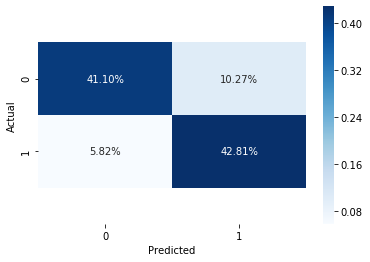

In [53]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Full model

Testing AUC: 0.870235


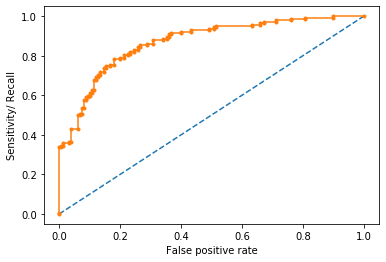

Logloss: 7.45
Accuracy: 78.42


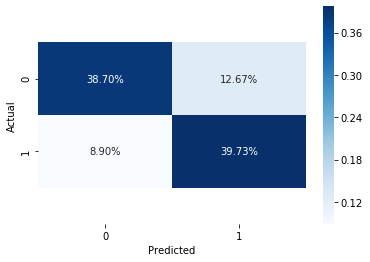

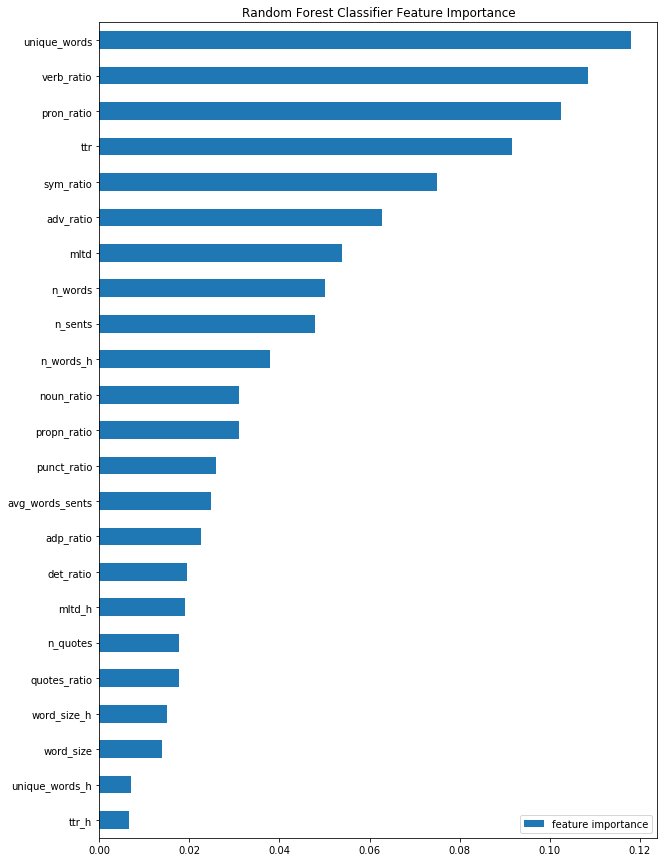

In [82]:
import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v4.csv')
y = df['label']

########### Features & train, test split ########### 

numerical_features = ['n_sents', 'n_words', 'avg_words_sents',
       'word_size', 'unique_words', 'ttr', 'mltd', 'n_words_h', 'word_size_h',
       'unique_words_h', 'ttr_h', 'mltd_h', 'n_quotes', 'quotes_ratio',
       'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio',
       'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

X = df[numerical_features].values
tfvocab = df[numerical_features].columns.tolist()

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### XGB CLassifier ########### 

rf_model = RandomForestClassifier(bootstrap = True, 
                                  n_estimators = 350, 
                                  max_depth = 80, 
                                  max_features = 'sqrt', 
                                  min_samples_leaf = 2,
                                  min_samples_split = 13, 
                                  random_state = 43)

rf_model.fit(X_train, y_train)


########### Predictions and results ###########

# predictions
y_pred = rf_model.predict(X_test)
probs = rf_model.predict_proba(X_test)
probs = probs[:, 1]

# testing AUC
auc = roc_auc_score(y_test, probs)
print('Testing AUC: %f' % auc)

# roc curve calculation
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)

# plot the limits for no skill
plt.plot([0, 1], [0, 1], linestyle = '--')

# plot the roc curve
plt.plot(false_positive_rate, true_positive_rate, marker = '.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
plt.show();

# accuracy score
print('Logloss: %.2f' % (log_loss(y_test, y_pred)))
print('Accuracy: %.2f' % (rf_model.score(X_test, y_test) * 100))

# confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1])
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True, fmt = '.2%', cmap = 'Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();


########### Feature importance ###########

dict_features = dict(enumerate(tfvocab))

# feature importance with default names

df_feature_importance = pd.DataFrame(rf_model.feature_importances_, index = tfvocab, 
                                     columns = ['feature importance']).sort_values('feature importance')

df_feature_all = pd.DataFrame([tree.feature_importances_ for tree in rf_model.estimators_], columns = tfvocab)
df_feature_long = pd.melt(df_feature_all, var_name = 'feature name', value_name = 'values')

fig, ax = plt.subplots(figsize = [10, 15])
df_feature_importance.plot(kind = 'barh', ax = ax, title = 'Random Forest Classifier Feature Importance');